# Section 1: Text preprocessing

## 1.1 Vanilla Text Preprocessing

In [1]:
import pandas as pd
import os
import types
import copy
from datetime import datetime
import re
import time
PATH = 'data'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# vanilla function of text cleaning
def clean_text(df: pd.DataFrame) -> pd.DataFrame:
    df = copy.deepcopy(df)
    keywords = ['Nvidia', 'GPU', 'processor']
    pattern = '|'.join(keywords)
    filtered = df[df['main_text'].str.contains(pattern, case=False, na=False)]
    # make a copy
    filtered = copy.deepcopy(filtered)
    filtered['main_text'] = [' '.join(s.split('\n')) for s in filtered['main_text']]
    return filtered


def convert_dt_str(date_string: str):
    pattern_1 = r'[a-zA-Z]+ [0-9]+ [0-9]+'
    cleaned = date_string.replace(',', '')
    match = re.search(pattern_1, cleaned)
    
    if match:
        date_string = match.group(0)
        date_format = '%B %d %Y'
        # Parse the date string into a datetime object
        date_object = datetime.strptime(date_string, date_format)

    else:
        date_object = None
        
    return date_object

In [3]:
# vanilla version driver code
files = os.listdir(PATH)

st = time.time()
cleaned_files = []
for f in files:
    df = pd.read_excel('/'.join([PATH, f]), header=0)
    print(f'Reading file {f}...')
    print(f'The length of unfiltered df is: {len(df)}')
    # apply the raw text cleaning to get related articles
    cleaned_files.append(clean_text(df))
    print(f'The length of filtered df is: {len(df)}')

agg_df = pd.concat(cleaned_files)
cols = agg_df.columns
agg_df = agg_df[cols[1:-2]]
agg_df['publish_date'] = agg_df['publish_date'].apply(lambda x: convert_dt_str(x))

et = time.time()
print(f'Time used: {et-st}')

# agg_df.to_csv('cleaned_data.csv', index=False)

Reading file foxnews.xlsx...
The length of unfiltered df is: 94
The length of filtered df is: 94
Reading file cnn.xlsx...
The length of unfiltered df is: 4674
The length of filtered df is: 4674
Time used: 0.8433270454406738


## 1.2: Cython Version of Text Preprocessing

In [29]:
%load_ext Cython 
# Below is the Cython implementation of the cleaner function

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [30]:
%%cython
from libc.stdlib cimport malloc, free
cimport numpy as np
cimport pandas as pd
import pandas as pd
import re
import copy
from datetime import datetime
from cpython cimport array
import array

cpdef object clean_text(object df):
    cdef:
        list keywords = ['Nvidia', 'GPU', 'processor']
        str pattern = '|'.join(keywords)
        object filtered

    # No deep copy needed as we don't modify input directly
    filtered = df[df['main_text'].str.contains(pattern, case=False, na=False)].copy()
    filtered['main_text'] = [' '.join(s.split('\n')) for s in filtered['main_text']]
    return filtered

cpdef object convert_dt_str(str date_string):
    cdef:
        str cleaned = date_string.replace(',', '')
        str pattern_1 = r'[a-zA-Z]+ [0-9]+ [0-9]+'
        object match

    match = re.search(pattern_1, cleaned)

    if match:
        date_string = match.group(0)
        return datetime.strptime(date_string, '%B %d %Y')
    else:
        return None


def clean_article_driver(list files, str PATH):
    cdef list cleaned_files
    
    cleaned_files = []
    for f in files:
        df = pd.read_excel('/'.join([PATH, f]), header=0)
        print(f'Reading file {f}...')
        print(f'The length of unfiltered df is: {len(df)}')

        # apply the raw text cleaning to get related articles
        cleaned_files.append(clean_text(df))
        print(f'The length of filtered df is: {len(df)}')

    agg_df = pd.concat(cleaned_files)
    cols = agg_df.columns
    agg_df = agg_df[cols[1:-2]]
    agg_df['publish_date'] = agg_df['publish_date'].apply(lambda x: convert_dt_str(x))

In [31]:
files = os.listdir(PATH)
st = time.time()
clean_article_driver(files, PATH)
et = time.time()
print(f'Time used: {et-st}')

Reading file foxnews.xlsx...
The length of unfiltered df is: 94
The length of filtered df is: 94
Reading file cnn.xlsx...
The length of unfiltered df is: 4674
The length of filtered df is: 4674
Time used: 0.6582248210906982


# Section 2: LDA experiments

## 2.1: Vanilla LDA Code

In [5]:
# run the cmd separately if not already installed
!pip install nltk
!pip install numba
!pip install spacy
!pip install gensim

In [6]:
!spacy download en_core_web_sm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.9 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nltk.util import ngrams

import cython
import numba
from numba import jit, njit, prange
import time


# NLTK Stop words
# uncomment following 2 lines if first time using nltk
# import nltk
# nltk.download()
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [90]:
# vanilla LDA
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
        
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    for docs in texts:
        docs.extend([' '.join(gram) for gram in ngrams(docs, 2)])
#     texts = [bigram_mod[doc] for doc in texts]
#     texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

    # texts_out = []
    # nlp = spacy.load("en_core_web_sm")
#     nlp = spacy.load('en', disable=['parser', 'ner'])
    # for sent in texts:
    #     doc = nlp(" ".join(sent)) 
    #     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization

    # texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]    
    # print(texts_out[:2])
    return texts

In [91]:

# Splitted functions version in order to benchmark for optimization

def initialize_lda(K, alpha, beta, num_iterations):
    lda = {
        "K": K,
        "alpha": alpha,
        "theta": None,
        "beta": beta,
        "phi": None,
        "num_iterations": num_iterations,
        "vocabulary": None
    }
    return lda

def build_vocabulary(documents):
    tempVocab = []
    for doc in documents:
        for word in doc:
            tempVocab.append(word)
    vocabulary = list(set(tempVocab))
    return vocabulary

def initialize_count_matrices(lda, documents):
    V = len(lda["vocabulary"])
    D = len(documents)
    n_k_i = np.zeros((lda["K"], V))
    n_k = np.zeros(lda["K"])
    n_j_k = np.zeros((D, lda["K"]))
    n_j = np.zeros(D)
    
    #topic_assignments = [[np.random.randint(0, lda["K"]) for _ in range(len(doc))] for doc in documents]
    topic_assignments = []
    for doc in documents:
        temp = []
        for _ in range(len(doc)):
            temp.append(np.random.randint(0, lda['K']))
        topic_assignments.append(temp)
    
    for d, doc in enumerate(documents):
        for i, word in enumerate(doc):
            topic = topic_assignments[d][i]
            word_idx = lda["vocabulary"].index(word)
            n_k_i[topic, word_idx] += 1
            n_k[topic] += 1
            n_j_k[d, topic] += 1
            n_j[d] += 1
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def gibbs_sampling(lda, documents, n_k_i, n_k, n_j_k, n_j, topic_assignments):
    for _ in range(lda["num_iterations"]):
        for d, doc in enumerate(documents):
            for i, word in enumerate(doc):
                topic = topic_assignments[d][i]
                word_idx = lda["vocabulary"].index(word)
                
                n_k_i[topic, word_idx] -= 1
                n_k[topic] -= 1
                n_j_k[d, topic] -= 1
                n_j[d] -= 1
                
                p_topic = (n_k_i[:, word_idx] + lda["beta"]) / (n_k + len(lda["vocabulary"]) * lda["beta"]) * (n_j_k[d] + lda["alpha"]) / (n_j[d] + lda["K"] * lda["alpha"])
                p_topic /= np.sum(p_topic)
                
                new_topic = np.random.multinomial(1, p_topic).argmax()
                
                n_k_i[new_topic, word_idx] += 1
                n_k[new_topic] += 1
                n_j_k[d, new_topic] += 1
                n_j[d] += 1
                
                topic_assignments[d][i] = new_topic
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j):
    lda["theta"] = (n_j_k + lda["alpha"]) / (n_j[:, np.newaxis] + lda["K"] * lda["alpha"])
    lda["phi"] = (n_k_i + lda["beta"]) / (n_k[:, np.newaxis] + len(lda["vocabulary"]) * lda["beta"])

def fit_lda(lda, documents):
    lda["vocabulary"] = build_vocabulary(documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = initialize_count_matrices(lda, documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = gibbs_sampling(lda, documents, n_k_i, n_k, n_j_k, n_j, topic_assignments)
    estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j)

def transform_lda(lda, documents):
    D = len(documents)
    theta = np.zeros((D, lda["K"]))
    
    for d, doc in enumerate(documents):
        topic_counts = np.zeros(lda["K"])
        for word in doc:
            if word in lda["vocabulary"]:
                word_idx = lda["vocabulary"].index(word)
                topic_probs = lda["phi"][:, word_idx]
                topic_probs /= np.sum(topic_probs)
                topic = np.random.multinomial(1, topic_probs).argmax()
                topic_counts[topic] += 1
        theta[d] = (topic_counts + lda["alpha"]) / (len(doc) + lda["K"] * lda["alpha"])
    
    return theta

def get_topics(lda, top_words=10):
    for topic_idx in range(lda["K"]):
        print(f"Topic {topic_idx+1}:")
        word_probs = lda["phi"][topic_idx]
        top_word_indices = word_probs.argsort()[-top_words:][::-1]
        top_words_list = [lda["vocabulary"][idx] for idx in top_word_indices]
        print(f"  Top words: {', '.join(top_words_list)}\n")




In [67]:
# prepare data
df = pd.read_csv('./input/cleaned_data.csv')
# Convert to list
data = df[:5000].main_text.values.tolist()
data_words = list(sent_to_words(data))
data_ready = process_words(data_words)  # processed Text Data!
# first 50 entries as subset
# subset = data_ready[:50]

In [71]:
len(data_ready)

117

In [72]:
len(data_ready[0])

343

In [92]:
# vanilla LDA driver code
K = 4
alpha = 0.1
beta = 0.1
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: inch, gb, graphics, core, new, nvidia, display, gaming, gpu, series

Topic 2:
  Top words: games, tablet, nvidia, tegra, game, google, gaming, one, like, device

Topic 3:
  Top words: nvidia, said, china, us, new, company, arm, chips, companies, deal

Topic 4:
  Top words: million, nvidia, year, share, said, company, quarter, ai, cents, cents share

Time used: 9998.198628902435


In [93]:
# vanilla LDA driver code
K = 8
alpha = 0.1
beta = 0.1
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: tablet, tegra, android, google, screen, device, new, tablets, first, devices

Topic 2:
  Top words: card, amd, cards, sync, pelosi, performance, refresh, rate, monitor, made

Topic 3:
  Top words: nvidia, said, china, chips, us, arm, company, deal, chip, new

Topic 4:
  Top words: foxconn, virtual, said, tesla, new, world, one, nvidia, year, vr

Topic 5:
  Top words: gb, inch, graphics, nvidia, core, display, notebook, new, drive, geforce

Topic 6:
  Top words: nvidia, year, ai, company, market, stock, said, billion, companies, wednesday

Topic 7:
  Top words: million, share, cents, cents share, quarter, year, revenue, said, million cents, inc

Topic 8:
  Top words: games, gaming, nvidia, game, shield, like, pc, play, well, available

Time used: 10014.557538032532


## 2.2: LDA Cythonize W/O Code Modification

In [83]:
%load_ext Cython

In [87]:
%%cython

# Splitted functions version in order for optimization
import numpy as np

# use a dictionary to simulate the class self.properties, the dictionary is the model
def initialize_lda(K, alpha, beta, num_iterations):
    lda = {
        "K": K,
        "alpha": alpha,
        "theta": None,
        "beta": beta,
        "phi": None,
        "num_iterations": num_iterations,
        "vocabulary": None
    }
    return lda


def build_vocabulary(documents):
    return list(set([word for doc in documents for word in doc]))


def encode_documents(documents, vocabulary):
    #vocabulary = list(set([word for doc in documents for word in doc]))
    word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    encoded_documents = []
    for doc in documents:
        encoded_doc = [word_to_index[word] for word in doc if word in word_to_index]
        encoded_documents.append(np.array(encoded_doc, dtype=np.int32))
    return encoded_documents

def initialize_count_matrices(K, D, V, encoded_documents):
    n_k_i = np.zeros((K, V), dtype=np.int32)
    n_k = np.zeros(K, dtype=np.int32)
    n_j_k = np.zeros((D, K), dtype=np.int32)
    n_j = np.zeros(D, dtype=np.int32)
    
    topic_assignments = []
    for doc in encoded_documents:
        doc_topic_assignments = np.random.randint(0, K, size=len(doc))#.astype(np.int32)
        topic_assignments.append(doc_topic_assignments)
    
    for d, doc in enumerate(encoded_documents):
        for i, word_idx in enumerate(doc):
            topic = topic_assignments[d][i]
            n_k_i[topic, word_idx] += 1
            n_k[topic] += 1
            n_j_k[d, topic] += 1
            n_j[d] += 1
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def gibbs_sampling(num_iterations, encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, K, alpha, beta, V):
    for _ in range(num_iterations):
        for d, doc in enumerate(encoded_documents):
            for i, word_idx in enumerate(doc):
                topic = topic_assignments[d][i]
                
                n_k_i[topic, word_idx] -= 1
                n_k[topic] -= 1
                n_j_k[d, topic] -= 1
                n_j[d] -= 1
                
                p_topic = (n_k_i[:, word_idx] + beta) / (n_k + V * beta) * (n_j_k[d] + alpha) / (n_j[d] + K * alpha)
                p_topic /= np.sum(p_topic)
                
                new_topic = np.random.multinomial(1, p_topic).argmax()
                
                n_k_i[new_topic, word_idx] += 1
                n_k[new_topic] += 1
                n_j_k[d, new_topic] += 1
                n_j[d] += 1
                
                topic_assignments[d][i] = new_topic
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j):
    lda["theta"] = (n_j_k + lda["alpha"]) / (n_j[:, np.newaxis] + lda["K"] * lda["alpha"])
    lda["phi"] = (n_k_i + lda["beta"]) / (n_k[:, np.newaxis] + len(lda["vocabulary"]) * lda["beta"])

def fit_lda(lda, documents):
    lda["vocabulary"] = build_vocabulary(documents)
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    n_k_i, n_k, n_j_k, n_j, topic_assignments = initialize_count_matrices(lda["K"], len(encoded_documents), len(lda["vocabulary"]), encoded_documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = gibbs_sampling(lda["num_iterations"], encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, lda["K"], lda["alpha"], lda["beta"], len(lda["vocabulary"]))
    estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j)

def transform_lda_helper(theta, encoded_documents, phi, alpha, K):
    for d, doc in enumerate(encoded_documents):
        topic_counts = np.zeros(K, dtype=np.int32)
        for word_idx in doc:
            topic_probs = phi[:, word_idx]
            topic_probs /= np.sum(topic_probs)
            topic = np.random.multinomial(1, topic_probs).argmax()
            topic_counts[topic] += 1
        theta[d] = (topic_counts + alpha) / (len(doc) + K * alpha)
    return theta

def transform_lda(lda, documents):
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    D = len(encoded_documents)
    theta = np.zeros((D, lda["K"]))
    theta = transform_lda_helper(theta, encoded_documents, lda["phi"], lda["alpha"], lda["K"])
    return theta

def get_topics(lda, top_words=10):
    for topic_idx in range(lda["K"]):
        print(f"Topic {topic_idx+1}:")
        word_probs = lda["phi"][topic_idx]
        top_word_indices = word_probs.argsort()[-top_words:][::-1]
        top_words_list = [lda["vocabulary"][idx] for idx in top_word_indices]
        print(f"  Top words: {', '.join(top_words_list)}\n")

In [88]:
K = 4
alpha = 0.1
beta = 0.1
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: said, nvidia, china, us, arm, companies, chips, new, company, deal

Topic 2:
  Top words: nvidia, year, million, share, said, company, quarter, ai, cents, cents share

Topic 3:
  Top words: inch, gb, graphics, nvidia, core, gaming, new, display, geforce, gpu

Topic 4:
  Top words: games, tablet, nvidia, tegra, game, google, gaming, device, shield, like

Time used: 1518.0760729312897


In [89]:
K = 8
alpha = 0.1
beta = 0.1
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: made, pelosi, people, said, switch, nintendo, news, tesla, information, speaker

Topic 2:
  Top words: gaming, games, nvidia, like, video, one, card, performance, game, pc

Topic 3:
  Top words: nvidia, china, said, chips, new, us, chip, business, company, companies

Topic 4:
  Top words: arm, deal, said, technology, nvidia, firm, united, softbank, companies, year

Topic 5:
  Top words: tablet, tegra, device, google, shield, android, tv, screen, play, game

Topic 6:
  Top words: nvidia, ai, year, company, market, billion, stock, said, quarter, dow

Topic 7:
  Top words: gb, inch, graphics, core, new, nvidia, display, drive, notebook, available

Topic 8:
  Top words: million, share, cents, cents share, year, quarter, million cents, said, revenue, inc

Time used: 1521.3256931304932


## 2.3: LDA Cythonize W Code Modification

In [84]:
%%cython
# Splitted functions version in order for optimization
import numpy as np
cimport numpy as cnp

# use a dictionary to simulate the class self.properties, the dictionary is the model
cpdef initialize_lda(int K, cnp.float64_t alpha, cnp.float64_t beta, int num_iterations):
    cdef dict lda = {
        "K": K,
        "alpha": alpha,
        "theta": None,
        "beta": beta,
        "phi": None,
        "num_iterations": num_iterations,
        "vocabulary": None
    }
    return lda


cpdef build_vocabulary(list documents):
    return list(set([word for doc in documents for word in doc]))


cpdef encode_documents(list documents, list vocabulary):
    #vocabulary = list(set([word for doc in documents for word in doc]))
    cdef dict word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    cdef list encoded_documents = []
    cdef list encoded_doc, doc
    for doc in documents:
        encoded_doc = [word_to_index[word] for word in doc if word in word_to_index]
        encoded_documents.append(np.array(encoded_doc, dtype=np.int32))
    return encoded_documents

cpdef initialize_count_matrices(int K, int D, int V, list encoded_documents):
    cdef cnp.ndarray[cnp.int32_t, ndim=2] n_k_i = np.zeros((K, V), dtype=np.int32)
    cdef cnp.ndarray[cnp.int32_t, ndim=1] n_k = np.zeros(K, dtype=np.int32)
    cdef cnp.ndarray[cnp.int32_t, ndim=2] n_j_k = np.zeros((D, K), dtype=np.int32)
    cdef cnp.ndarray[cnp.int32_t, ndim=1] n_j = np.zeros(D, dtype=np.int32)
    
    cdef list topic_assignments = []
    cdef cnp.ndarray[cnp.int32_t, ndim=1] doc_topic_assignments
    for doc in encoded_documents:
        doc_topic_assignments = np.random.randint(0, K, size=len(doc), dtype=np.int32)#.astype(np.int32)
        topic_assignments.append(doc_topic_assignments)
        
    cdef int d, i, topic
    for d, doc in enumerate(encoded_documents):
        for i, word_idx in enumerate(doc):
            topic = topic_assignments[d][i]
            n_k_i[topic, word_idx] += 1
            n_k[topic] += 1
            n_j_k[d, topic] += 1
            n_j[d] += 1
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

cpdef gibbs_sampling(int num_iterations, list encoded_documents, 
                     cnp.ndarray[cnp.int32_t, ndim=2] n_k_i, cnp.ndarray[cnp.int32_t, ndim=1] n_k, 
                     cnp.ndarray[cnp.int32_t, ndim=2] n_j_k, cnp.ndarray[cnp.int32_t, ndim=1] n_j, 
                     list topic_assignments, int K, cnp.float64_t alpha, cnp.float64_t beta, int V):
    cdef int d, i, topic, new_topic
    cdef cnp.ndarray[cnp.float64_t, ndim=1] p_topic
    for _ in range(num_iterations):
        for d, doc in enumerate(encoded_documents):
            for i, word_idx in enumerate(doc):
                topic = topic_assignments[d][i]
                
                n_k_i[topic, word_idx] -= 1
                n_k[topic] -= 1
                n_j_k[d, topic] -= 1
                n_j[d] -= 1
                
                p_topic = (n_k_i[:, word_idx] + beta) / (n_k + V * beta) * (n_j_k[d] + alpha) / (n_j[d] + K * alpha)
                p_topic /= np.sum(p_topic)
                
                new_topic = np.random.multinomial(1, p_topic).argmax()
                
                n_k_i[new_topic, word_idx] += 1
                n_k[new_topic] += 1
                n_j_k[d, new_topic] += 1
                n_j[d] += 1
                
                topic_assignments[d][i] = new_topic
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

cpdef estimate_parameters(dict lda, 
                          cnp.ndarray[cnp.int32_t, ndim=2] n_k_i, cnp.ndarray[cnp.int32_t, ndim=1] n_k, 
                          cnp.ndarray[cnp.int32_t, ndim=2] n_j_k, cnp.ndarray[cnp.int32_t, ndim=1] n_j):
    lda["theta"] = (n_j_k + lda["alpha"]) / (n_j[:, np.newaxis] + lda["K"] * lda["alpha"])
    lda["phi"] = (n_k_i + lda["beta"]) / (n_k[:, np.newaxis] + len(lda["vocabulary"]) * lda["beta"])

cpdef fit_lda(dict lda, list documents):
    lda["vocabulary"] = build_vocabulary(documents)
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    n_k_i, n_k, n_j_k, n_j, topic_assignments = initialize_count_matrices(lda["K"], len(encoded_documents), len(lda["vocabulary"]), encoded_documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = gibbs_sampling(lda["num_iterations"], encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, lda["K"], lda["alpha"], lda["beta"], len(lda["vocabulary"]))
    estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j)

cpdef transform_lda_helper(cnp.ndarray[cnp.float64_t, ndim=2] theta, list encoded_documents, 
                           cnp.ndarray[cnp.float64_t, ndim=2] phi, 
                           cnp.float64_t alpha, int K):
    cdef cnp.ndarray[cnp.int32_t, ndim=1] topic_counts
    cdef cnp.ndarray[cnp.float64_t, ndim=1] topic_probs
    
    cdef int d, word_idx, topic
    for d, doc in enumerate(encoded_documents):
        topic_counts = np.zeros(K, dtype=np.int32)
        for word_idx in doc:
            topic_probs = phi[:, word_idx]
            topic_probs /= np.sum(topic_probs)
            topic = np.random.multinomial(1, topic_probs).argmax()
            topic_counts[topic] += 1
        theta[d] = (topic_counts + alpha) / (len(doc) + K * alpha)
    return theta

cpdef transform_lda(dict lda, list documents):
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    cdef int D = len(encoded_documents)
    cdef cnp.ndarray[cnp.float64_t, ndim=2] theta = np.zeros((D, lda["K"]), dtype=np.float64)
    theta = transform_lda_helper(theta, encoded_documents, lda["phi"], lda["alpha"], lda["K"])
    return theta

cpdef get_topics(dict lda, int top_words=10):
    cdef int topic_idx, idx
    for topic_idx in range(lda["K"]):
        print(f"Topic {topic_idx+1}:")
        word_probs = lda["phi"][topic_idx]
        top_word_indices = word_probs.argsort()[-top_words:][::-1]
        top_words_list = [lda["vocabulary"][idx] for idx in top_word_indices]
        print(f"  Top words: {', '.join(top_words_list)}\n")

In [85]:
K = 4
alpha = 0.1
beta = 0.01
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: nvidia, company, said, ai, year, chips, billion, new, market, companies

Topic 2:
  Top words: graphics, inch, gb, new, core, nvidia, display, gaming, well, card

Topic 3:
  Top words: million, share, year, said, cents, quarter, cents share, revenue, million cents, first

Topic 4:
  Top words: games, tablet, tegra, game, google, like, device, gaming, nvidia, shield

Time used: 944.4103379249573


In [86]:
K = 8
alpha = 0.1
beta = 0.01
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: nvidia, new, one, like, graphics, two, technology, gaming, time, card

Topic 2:
  Top words: games, game, google, gaming, device, shield, play, tv, streaming, gamers

Topic 3:
  Top words: tablet, screen, tegra, first, tablets, inch, display, core, ipad, processor

Topic 4:
  Top words: gb, inch, core, drive, display, notebook, geforce, new, hd, graphics

Topic 5:
  Top words: million, share, cents, quarter, cents share, year, revenue, said, million cents, inc

Topic 6:
  Top words: made, sync, people, pelosi, said, tesla, digital, sec, speaker, research

Topic 7:
  Top words: nvidia, ai, year, company, market, stock, billion, companies, wednesday, huang

Topic 8:
  Top words: china, said, nvidia, us, chips, arm, company, deal, tech, chip

Time used: 954.409096956253


## 2.4: LDA Numba

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import cython
import numba
from numba import jit, njit, prange
import time

In [76]:
# Splitted functions version in order for optimization
import numpy as np
from numba import jit, types

# use a dictionary to simulate the class self.properties, the dictionary is the model
def initialize_lda(K, alpha, beta, num_iterations):
    lda = {
        "K": K,
        "alpha": alpha,
        "theta": None,
        "beta": beta,
        "phi": None,
        "num_iterations": num_iterations,
        "vocabulary": None
    }
    return lda

def build_vocabulary(documents):
    return list(set([word for doc in documents for word in doc]))

# Numba is having trouble compiling the code due to the presence of 
# reflected containers (lists of lists) with Unicode elements.
# So here convert to simper arrays
# looks a bit awkward, other better options?
def encode_documents(documents, vocabulary):
    #vocabulary = list(set([word for doc in documents for word in doc]))
    word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    encoded_documents = []
    for doc in documents:
        encoded_doc = [word_to_index[word] for word in doc if word in word_to_index]
        encoded_documents.append(np.array(encoded_doc, dtype=np.int32))
    return encoded_documents

@jit(nopython=True)
def initialize_count_matrices(K, D, V, encoded_documents):
    n_k_i = np.zeros((K, V), dtype=np.int32)
    n_k = np.zeros(K, dtype=np.int32)
    n_j_k = np.zeros((D, K), dtype=np.int32)
    n_j = np.zeros(D, dtype=np.int32)
    
    topic_assignments = []
    for doc in encoded_documents:
        doc_topic_assignments = np.random.randint(0, K, size=len(doc))#.astype(np.int32)
        topic_assignments.append(doc_topic_assignments)
    
    for d, doc in enumerate(encoded_documents):
        for i, word_idx in enumerate(doc):
            topic = topic_assignments[d][i]
            n_k_i[topic, word_idx] += 1
            n_k[topic] += 1
            n_j_k[d, topic] += 1
            n_j[d] += 1
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

@jit(nopython=True)
def gibbs_sampling(num_iterations, encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, K, alpha, beta, V):
    for _ in range(num_iterations):
        for d, doc in enumerate(encoded_documents):
            for i, word_idx in enumerate(doc):
                topic = topic_assignments[d][i]
                
                n_k_i[topic, word_idx] -= 1
                n_k[topic] -= 1
                n_j_k[d, topic] -= 1
                n_j[d] -= 1
                
                p_topic = (n_k_i[:, word_idx] + beta) / (n_k + V * beta) * (n_j_k[d] + alpha) / (n_j[d] + K * alpha)
                p_topic /= np.sum(p_topic)
                
                new_topic = np.random.multinomial(1, p_topic).argmax()
                
                n_k_i[new_topic, word_idx] += 1
                n_k[new_topic] += 1
                n_j_k[d, new_topic] += 1
                n_j[d] += 1
                
                topic_assignments[d][i] = new_topic
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j):
    lda["theta"] = (n_j_k + lda["alpha"]) / (n_j[:, np.newaxis] + lda["K"] * lda["alpha"])
    lda["phi"] = (n_k_i + lda["beta"]) / (n_k[:, np.newaxis] + len(lda["vocabulary"]) * lda["beta"])

def fit_lda(lda, documents):
    lda["vocabulary"] = build_vocabulary(documents)
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    n_k_i, n_k, n_j_k, n_j, topic_assignments = initialize_count_matrices(lda["K"], len(encoded_documents), len(lda["vocabulary"]), encoded_documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = gibbs_sampling(lda["num_iterations"], encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, lda["K"], lda["alpha"], lda["beta"], len(lda["vocabulary"]))
    estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j)

@jit(nopython=True)
def transform_lda_helper(theta, encoded_documents, phi, alpha, K):
    for d, doc in enumerate(encoded_documents):
        topic_counts = np.zeros(K, dtype=np.int32)
        for word_idx in doc:
            topic_probs = phi[:, word_idx]
            topic_probs /= np.sum(topic_probs)
            topic = np.random.multinomial(1, topic_probs).argmax()
            topic_counts[topic] += 1
        theta[d] = (topic_counts + alpha) / (len(doc) + K * alpha)
    return theta

def transform_lda(lda, documents):
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    D = len(encoded_documents)
    theta = np.zeros((D, lda["K"]))
    theta = transform_lda_helper(theta, encoded_documents, lda["phi"], lda["alpha"], lda["K"])
    return theta

def get_topics(lda, top_words=10):
    for topic_idx in range(lda["K"]):
        print(f"Topic {topic_idx+1}:")
        word_probs = lda["phi"][topic_idx]
        top_word_indices = word_probs.argsort()[-top_words:][::-1]
        top_words_list = [lda["vocabulary"][idx] for idx in top_word_indices]
        print(f"  Top words: {', '.join(top_words_list)}\n")


In [77]:
K = 4
alpha = 0.1
beta = 0.01
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: million, share, said, year, cents, quarter, cents share, revenue, million cents, first

Topic 2:
  Top words: graphics, inch, gb, core, nvidia, tablet, display, available, new, geforce

Topic 3:
  Top words: games, gaming, new, one, nvidia, game, like, chip, pc, video

Topic 4:
  Top words: nvidia, company, said, ai, year, chips, market, billion, companies, china

Time used: 20.61978316307068


In [78]:
K = 8
alpha = 0.1
beta = 0.01
num_iterations = 1000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
fit_lda(lda, data_ready)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: inch, gb, graphics, core, drive, display, nvidia, notebook, available, resolution

Topic 2:
  Top words: said, nvidia, china, chips, us, arm, deal, chip, companies, tech

Topic 3:
  Top words: million, share, cents, said, cents share, quarter, revenue, year, million cents, first

Topic 4:
  Top words: nvidia, year, ai, company, market, stock, billion, huang, street, wednesday

Topic 5:
  Top words: new, graphics, one, nvidia, card, amd, well, gaming, two, performance

Topic 6:
  Top words: people, made, information, pelosi, said, computer, tesla, reports, stock, research

Topic 7:
  Top words: games, game, nvidia, gaming, shield, device, tv, play, google, geforce

Topic 8:
  Top words: tablet, tegra, screen, one, chip, first, tablets, version, android, core

Time used: 21.212605953216553


# Section 3: N-gram and Visualization

In [ ]:
#import xlsx
df = pd.read_excel('data/foxnews.xlsx')
df.head()
df['text'] = df['main_text'].apply(lambda x: clean_text(x, ngram = 1))


In [16]:
lda['theta'].shape

(75, 4)

In [33]:
# create a dataframe with rows being vocabulary and columns being topics
df_phi = pd.DataFrame(lda['phi'], columns=lda['vocabulary']).T
df_phi.head()

,0,1,2,3
playlist,0.000004,0.000004,0.000173,0.000002
perfectly,0.000004,0.000004,0.000173,0.000002
reinsurers,0.000004,0.000765,0.000002,0.000002
us,0.002907,0.002758,0.992788,0.001547
dam,0.000405,0.000004,0.000002,0.000002


In [ ]:
doc_lens = [len(d) for d in df['text']]

plt.hist(doc_lens, color='navy')

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
# create a dataframe with rows being vocabulary and columns being topics
df_phi = pd.DataFrame(lda['phi'], columns=lda['vocabulary']).T
df_phi.head()

In [41]:
# create a train dataframe with rows being documents and columns being topics
df_theta = pd.DataFrame(lda['theta'])

# add a column of topic assigned
topic_assinged = lda['theta'].argmax(axis=1)
df_theta['topic'] = topic_assinged

# add a column of main_text
df_theta['main_text_tokenized'] = X_train.reset_index(drop=True)
df_theta.head()

,0,1,2,3,topic,main_text_tokenized
0,0.110150,0.000577,0.473472,0.415802,2,"[ce, remembered, one, thing, display, technolo..."
1,0.081378,0.081378,0.682551,0.154692,2,"[nvidias, relatively, recent, release, gtx, ti..."
2,0.001119,0.023490,0.884787,0.090604,2,"[youre, gamer, business, user, need, new, lapt..."
3,0.633255,0.059355,0.106525,0.200865,0,"[thomas, markle, apparently, wasnt, impressed,..."
4,0.552810,0.203973,0.082849,0.160368,0,"[decade, died, penniless, nikola, tesla, elbow..."


In [42]:
# create a test dataframe with rows being documents and columns being topics
df_theta_test = pd.DataFrame(theta)

# add a column of topic assigned
topic_assinged = theta.argmax(axis=1)
df_theta_test['topic'] = topic_assinged

# add a column of main_text
df_theta_test['main_text_tokenized'] = X_test.reset_index(drop=True)
df_theta_test.head()

,0,1,2,3,topic,main_text_tokenized
0,0.109813,0.070872,0.608255,0.211059,2,"[proving, slim, mean, underpowered, asus, toda..."
1,0.053792,0.080247,0.397707,0.468254,3,"[year, computex, trade, show, taipei, amidst, ..."
2,0.153113,0.089581,0.286531,0.470775,3,"[nintendo, switch, available, buy, little, yea..."
3,0.018836,0.104452,0.686644,0.190068,2,"[freshly, minted, macbook, pro, town, announce..."
4,0.072443,0.086648,0.740057,0.100852,2,"[poor, alienware, mx, hardly, knew, ye, two, y..."


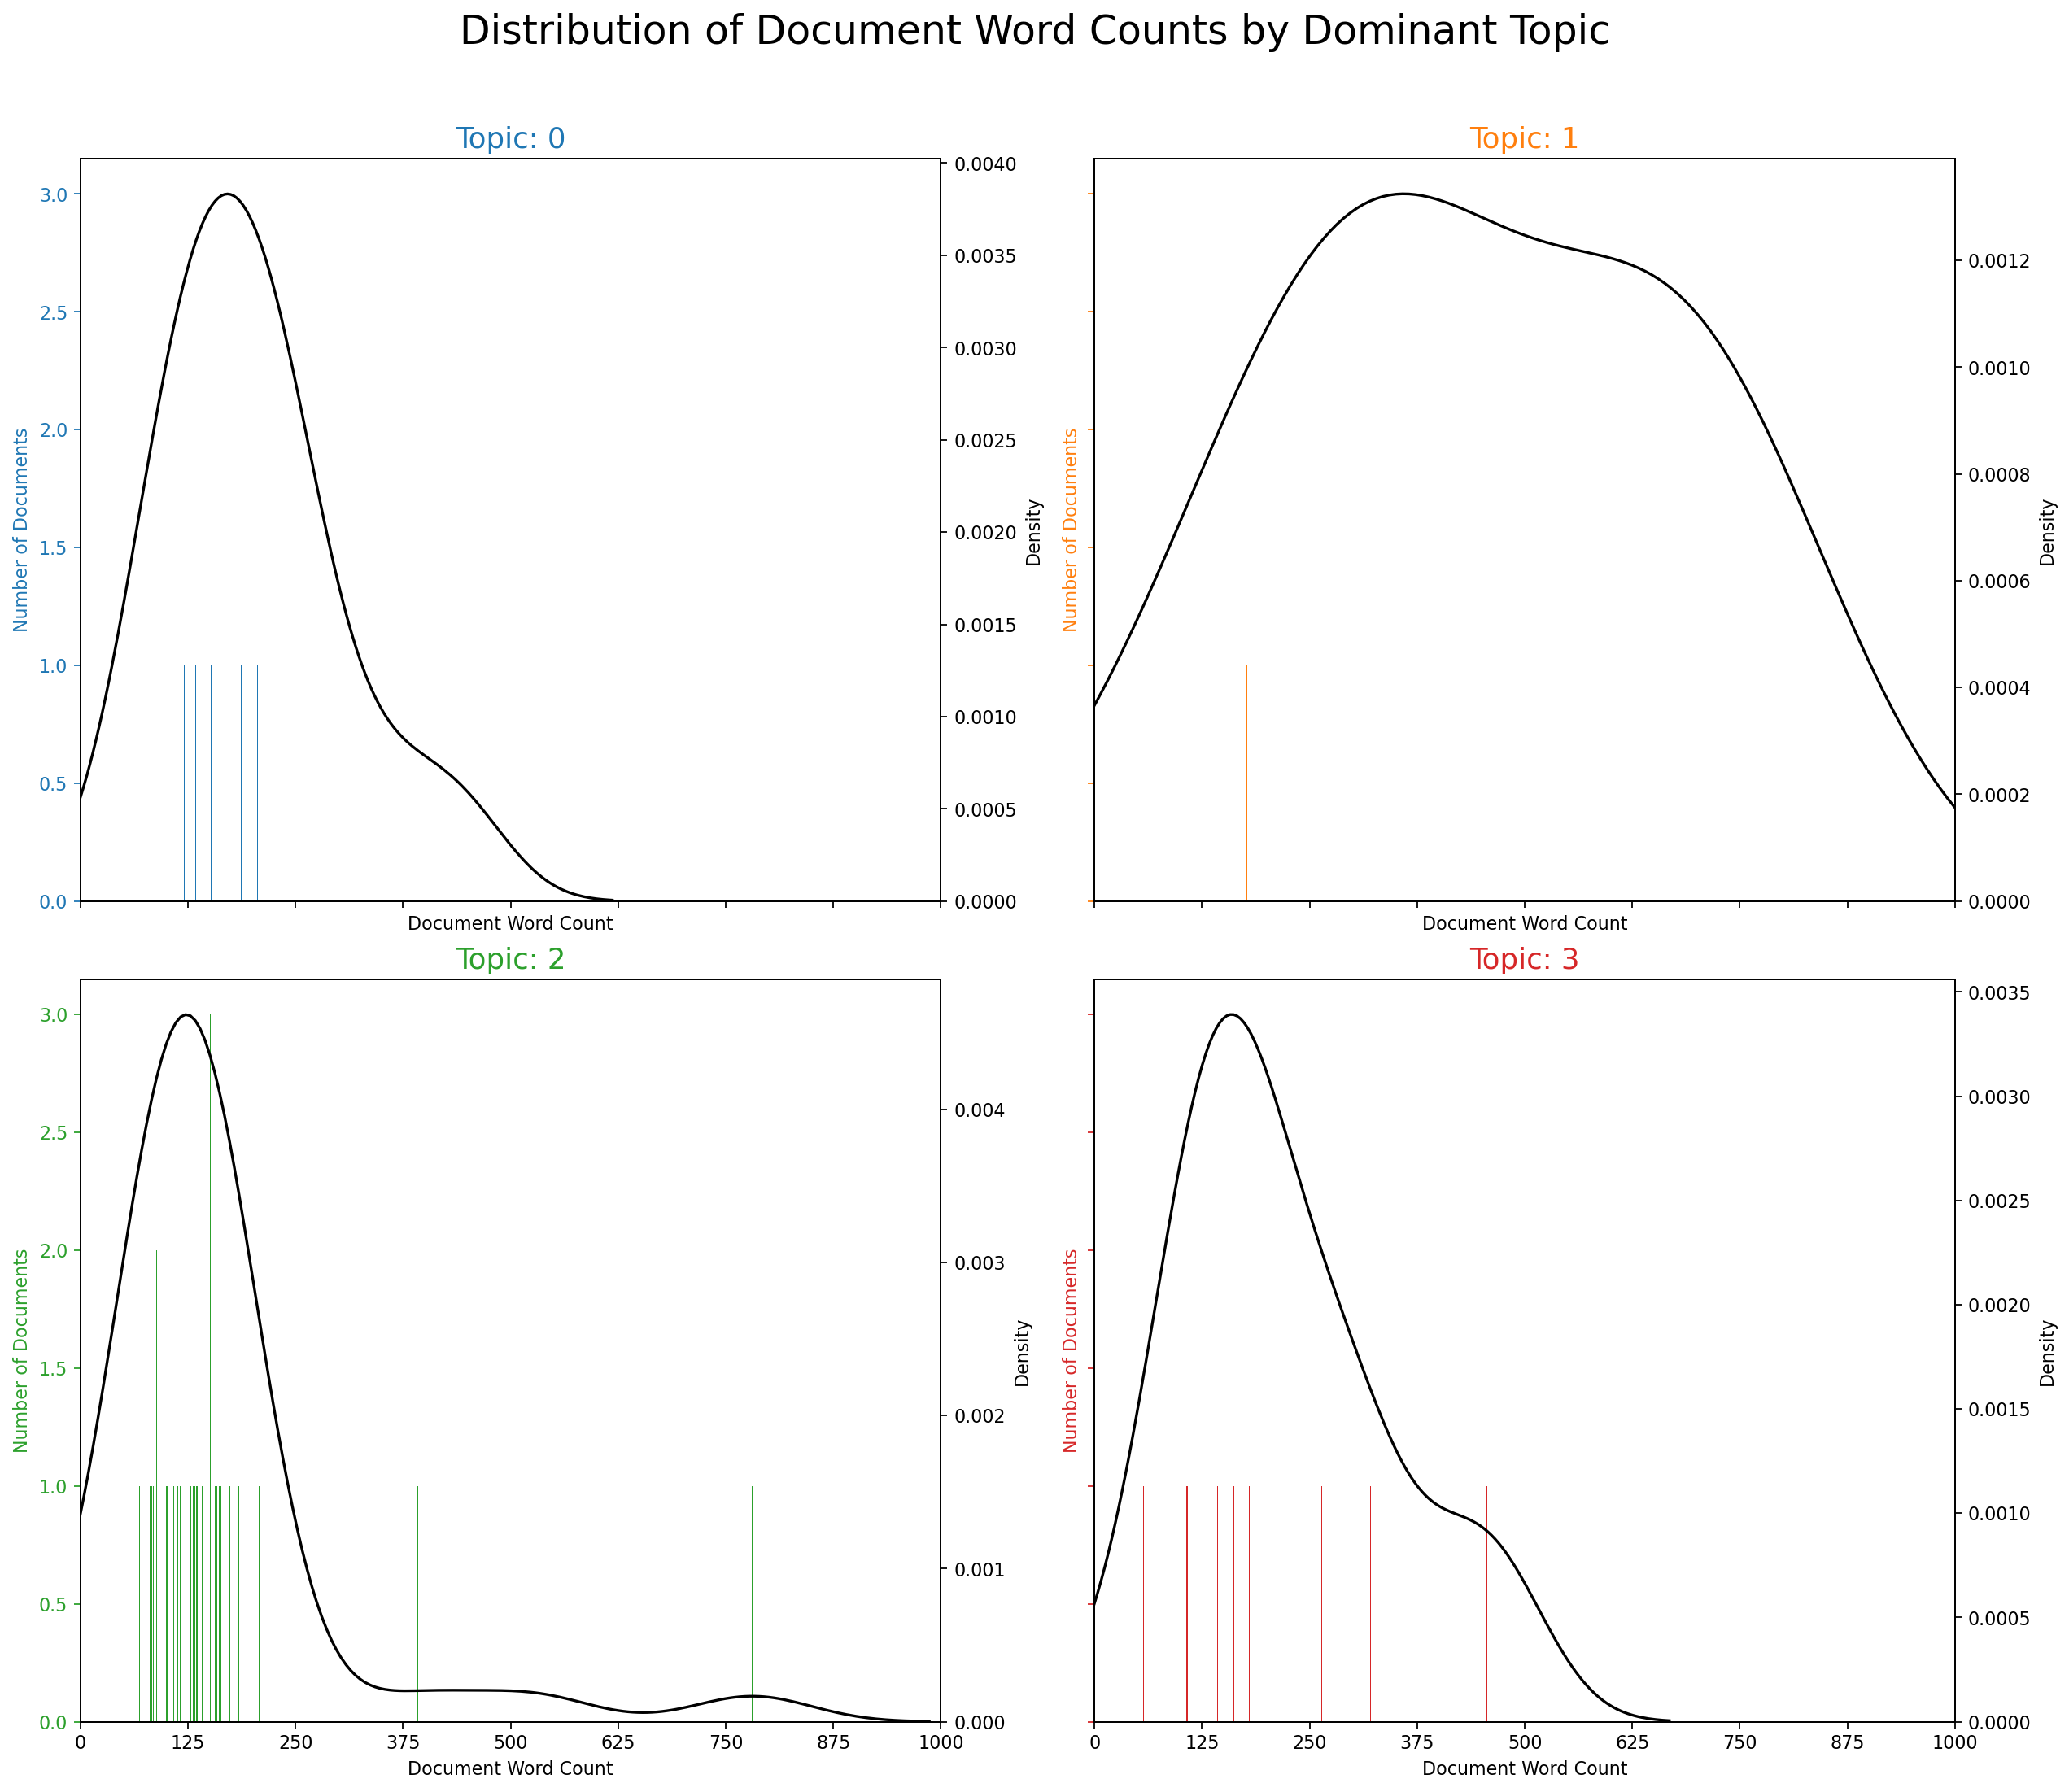

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Sample DataFrame lda_df
# lda_df = ...

# Sample data
# Assuming lda_df has columns [0, 1, 2, 3, 'topic', 'main_text_tokenized']

# Generate colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_theta.loc[df_theta['topic'] == i, :]
    doc_lens = [len(tokens) for tokens in df_dominant_topic_sub['main_text_tokenized']]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()


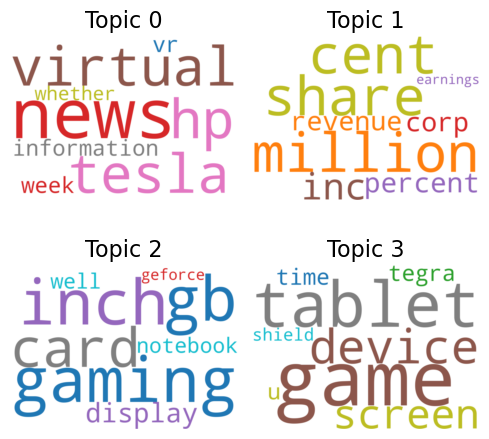

In [54]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Sample DataFrame df_topics
# df_topics = ...

# Generate colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create a WordCloud object
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=8,
                  colormap='tab10',
                  prefer_horizontal=1.0)

# Assuming lda_model.show_topics(formatted=False) returns a list of topics
topics = ["Topic {}".format(i) for i in range(len(df_phi.columns))]  # Create topics list

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(df_phi.iloc[:, i])  # Extract topic words from DataFrame
    cloud.generate_from_frequencies(topic_words)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(topics[i], fontdict=dict(size=16))
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


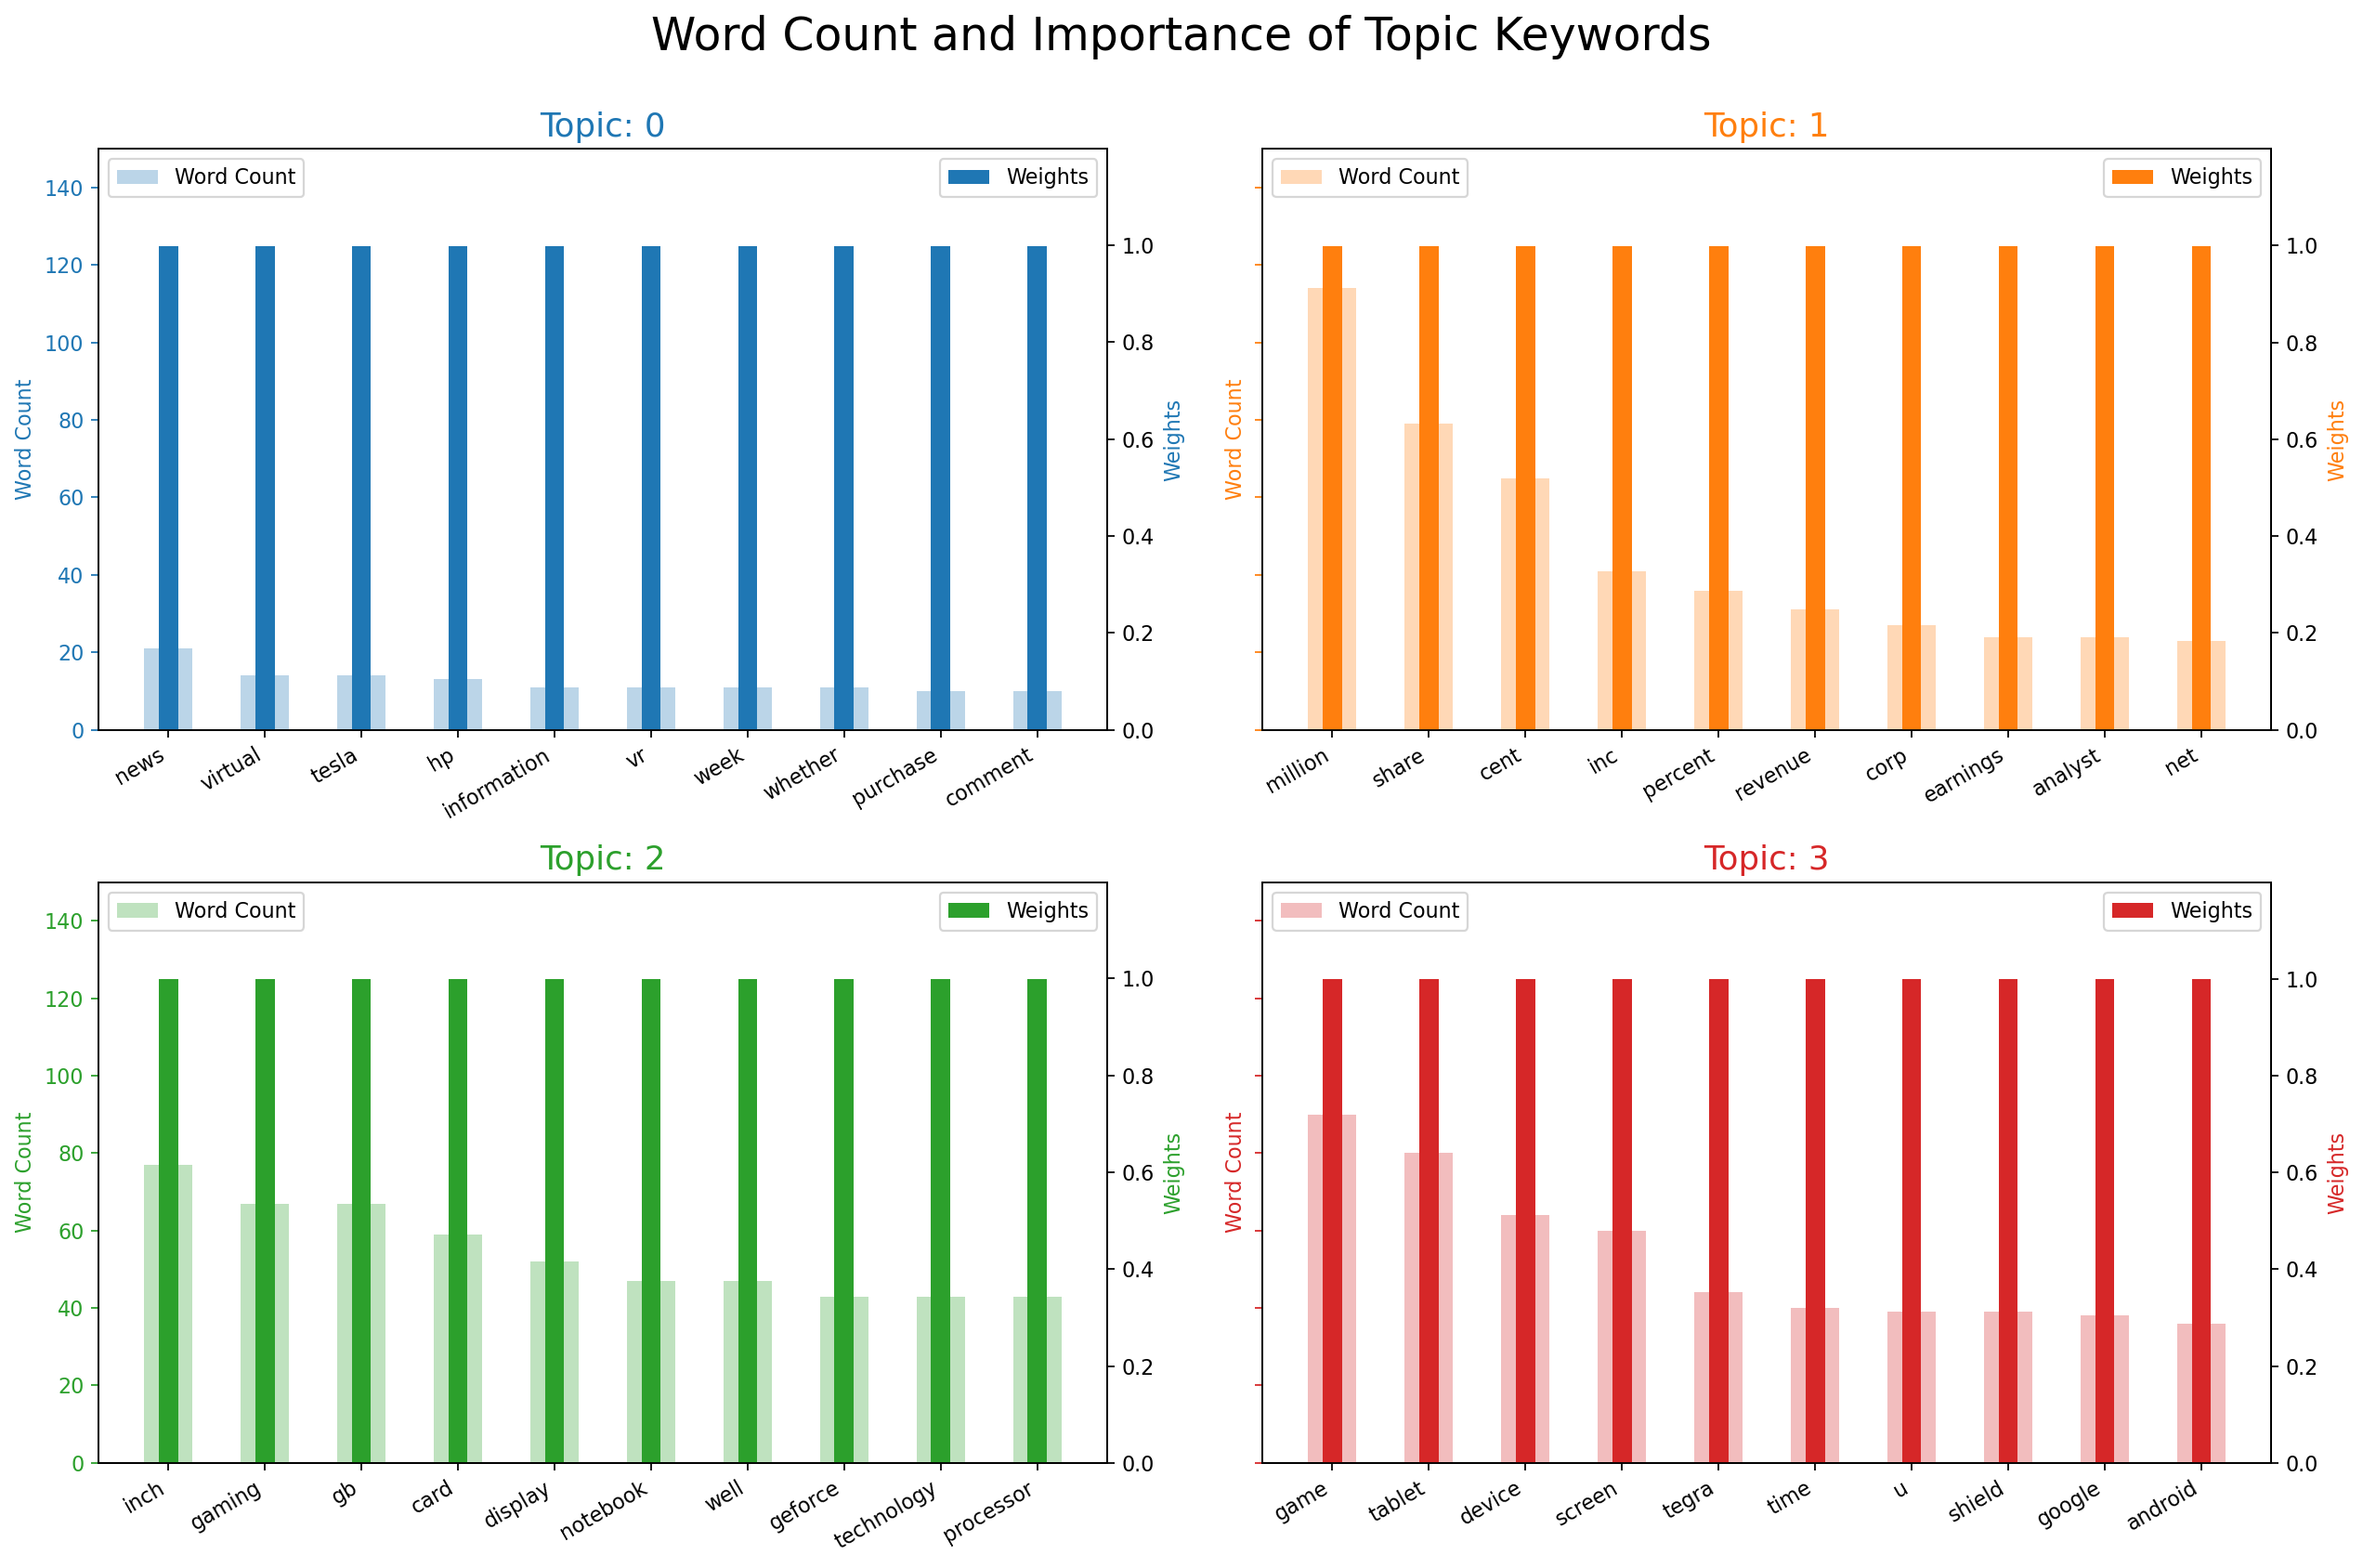

In [66]:
from collections import Counter

# Sample DataFrames df_phi and df_theta
# df_phi = ...
# df_theta = ...

# Extract topic words from df_phi
topics = df_phi.columns

# Flatten the tokenized text in df_theta
data_flat = [word for sublist in df_theta['main_text_tokenized'] for word in sublist]

# Count the occurrence of each word in the corpus
counter = Counter(data_flat)

out = []

# Iterate over topics
for i, topic in enumerate(topics):
    # Iterate over vocabularies and probabilities in the topic
    for word, prob in df_phi[[topic]].iterrows():
        # Append word, topic id, importance (probability), and word count to the out list
        out.append([word, topic, prob.values[0], counter[word]])

# Create DataFrame from out list
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Sort DataFrame by importance within each topic
df_sorted = df.groupby('topic_id').apply(lambda x: x.nlargest(10, 'importance')).reset_index(drop=True)

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    # Filter DataFrame for the current topic_id
    df_topic = df_sorted[df_sorted['topic_id'] == topics[i]]
    ax.bar(x='word', height='word_count', data=df_topic, color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=df_topic, color=cols[i], width=0.2, label='Weights')
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylim(0, df_topic['importance'].max() * 1.2)  # Adjust ylim for importance
    ax.set_ylim(0, 150)  # Adjust ylim for word count
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', colors=cols[i])
    ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()
